# Inference and Trajectory Forecasting with TrajCast

This notebook provides a short guide on how to deploy a *TrajCast* model. Here, we will focus on single forward passeses as well as performing a roll-out to forecast a trajectory for paracetamol. 


This tutorial covers: 
- Loading a previously trained model.
- Single-step prediction for validation based on small test set.
- Performing roll-out to forecast a short trajectory for paracetmol.

> **_Note_:** 
> This notebook won't cover model training. For details on how to train *TrajCast* please refer to this [example notebook](../training/training.ipynb).



> **_Note_:** 
> This code is still under development. This notebook is intended to provide help and guidance in getting started. Future updates will focus on making the code more efficient and user-friendly.

# Loading a Model 

We start by downloading the model weights from HuggingFace. Here, we use the model reported in our manuscript for paracetamol with a prediction horizon of 7 fs.

In [1]:
from huggingface_hub import hf_hub_download

for file in ["state_dict_e3nn.pt", "config_e3nn.yaml"]:
    hf_hub_download(
        repo_id="ibm-research/trajcast.models-arxiv2025",
        revision="main",
        filename=f"paracetamol/{file}",
        local_dir="./",
    )

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

As all models in our work were trained using double precision, we set this as default type.

In [3]:
torch.set_default_dtype(torch.float64)

With weights and configuration YAML file at hand, we can load and instantiate our model.

> **_Note_:** 
> Choose the state dictionary dependent on whether you have CUDA and cuEquivariance installed. For transferabilitiy, here we use the e3nn dictionary to allow running on a CPU. In general, to convert configuration YAMLs and state dictionaries from one O3 backend to the other, please use [this script](../../trajcast/cli/convert_o3_backend.py). Be aware, however, that dependent on the device where a model with cueq backend is initialized, some parameter names might vary.

In [4]:
from trajcast.model.models import EfficientTrajCastModel

# initialize model
model = EfficientTrajCastModel.build_from_yaml("paracetamol/config_e3nn.yaml")

# # load state dictionary
model.load_state_dict(
    torch.load(
        "paracetamol/state_dict_e3nn.pt",
        map_location=device,
    )
)

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/var/folders/jy/gb1zk7r56rj_pr65s2sm_yb00000gn/T/ipykernel_67644/2698563331.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

# Single-step Inference

Once we have our model, let's use it to validate it's performance on a hold out test set. Here, we use a 10% subset of the test set for which we reported errors in our original manuscript.

If not done so already, we start by downloading the dataset from HuggingFace:

In [5]:
for dataset in ["test"]:
    hf_hub_download(
        repo_id="ibm-research/trajcast.datasets-arxiv2025",
        repo_type="dataset",
        revision="main",
        filename=f"example/{dataset}.extxyz",
        local_dir="../data",
    )

Next, we load it using our `AtomicGraphDataset` class.

In [6]:
from trajcast.data.dataset import AtomicGraphDataset

test_set_dict = {
    "root": ".",  # Directory where the data lies
    "name": "paracetamol_test",  # Name the processed dataset should have
    "cutoff_radius": 4.0,  # Cutoff for defining edges between nodes, should be the same as for model, will be fixed later
    "files": [
        "../data/example/test.extxyz"
    ],  # Files with the data, can be multiple ones
    "rename": True,  # Dependent on the precision it will add a tag to the processed filename
    "atom_type_mapper": {  # Mapping chemical atom types to variables within the model, not necessary but less error prone
        1: 0,  # H -> 0
        6: 1,  # C -> 1
        7: 2,  # N -> 2
        8: 3,  # O -> 3
    },
}

test_set = AtomicGraphDataset(**test_set_dict)

/Users/fabianthiemann/Projects/01_TrajCast/paper/oss/trajcast_dev/trajcast/data/dataset.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.l

Now we can pass configurations to our model and perform a forward pass to predict the displacement vectors and new velocities. However, as the current implementation of *TrajCast* returns these quantaties normalized by the RMS of these vectors observed in the training set. The scaling constants are easily accessible via:

In [7]:
vel_scale = model._encoding.Normalization.stds["update_velocities"].item()
disp_scale = model._encoding.Normalization.stds["displacements"].item()

We then can create a dataloader and loop over our test set. As can be seen from the config.yaml files, the normalized predicted outputs are stored in a field called `target`.

In [8]:
from torch_geometric.loader import DataLoader
import numpy as np

data_loader = DataLoader(test_set, batch_size=5, shuffle=False)

# get true displacements and update velociites
true_vel = test_set.update_velocities.detach().numpy()
true_disp = test_set.displacements.detach().numpy()

model.eval()
pred_vel = []
pred_disp = []
model.to(device)
with torch.no_grad():
    for batch in data_loader:
        # forward pass
        batch = model(batch.to(device))

        # save predicted displacements and velocities
        pred_disp.append(batch.target[:, 0:3].cpu().numpy() * disp_scale)
        pred_vel.append(batch.target[:, 3:].cpu().numpy() * vel_scale)

pred_disp = np.concatenate(pred_disp)
pred_vel = np.concatenate(pred_vel)

To visually inspect the accuracy of our model, we create a parity plot for the displacements: 

Text(0.5, 0, 'Reference Displacements $[\\mathrm{\\AA}]$')

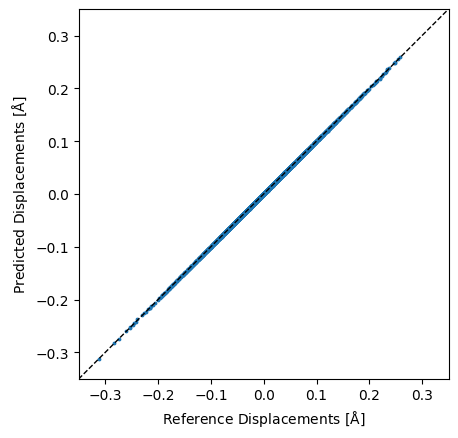

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")

ax.scatter(true_disp, pred_disp, s=3)
ax.plot([-0.4, 0.4], [-0.4, 0.4], color="k", ls="--", lw=1)

ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.35, 0.35)
ax.set_ylabel(r"Predicted Displacements $[\mathrm{\AA}]$")
ax.set_xlabel(r"Reference Displacements $[\mathrm{\AA}]$")

Assuming we are happy with this overall performance, we can now move to rolling out our predictions.

# Roll-out and Trajectory Forecasting

Similar to setting up traditional MD simulations, we start by defining our initial configuration. For the sake of simplicity, here we simply take one configuratino of the example test but remove the reference labels.

In [10]:
import ase.io

start_frame = ase.io.read(
    "../data/example/test.extxyz",
    index="-1",
)
start_frame.center()
_ = start_frame.arrays.pop("displacements")
_ = start_frame.arrays.pop("update_velocities")

Apart from the initial structure, we need to define a few settings in a forecasting protocol. 

In [11]:
protocol = {
    "units": "real",  # Units, in which the trajectory forecasting is performed. Here we use the same convention as lammps: https://docs.lammps.org/units.html
    "run": 100,  # Number of steps to be performed
    "temperature": 300.0,  # Target temperature
    "extra_dof": 6,  # Number of degrees of freedom to be subtracted from 3N for temperature definition.
    "timestep": 7.0,  # Prediction horizon the model has been trained on
    "configuration": start_frame,  # Initial configuration
    "model_type": "EfficientTrajCastModel",  # Type of model to be used
    "model": model,  # Which model to use
    "thermostat": {
        "Tdamp": 70.0
    },  # Arguments for the thermostat, if no thermostat is specified, forecast will be in NVE ensemble
    "velocities": {  # Whether to assign initial velocities (otherwise read from start_frame)
        "Temperature": 300,  # Velocities will correspond to this temperature
        "linear": True,  # Whether assigned velocities should be free of total linear momentum
        "angular": True,  # Whether assigned velocities should be free of total angular momentum
        "distribution": "gaussian",  # Distribution from which velocities are drawn (uniform or Gaussian)
    },
    "write": {  # Details on how often and where to save frames
        "filename": "./example_traj.extxyz",  # Path to the output file
        "every": 1,  # Save every Nth frame
    },
    "device": device,  # Device the forecasting will be run on
    "seed": 42,  # Seed for thermostat and initial velocities (if applicable)
    "set_momenta": {  # Directionary with target linear and/or angular momentum
        "linear": torch.zeros(3, device=device),
        "angular": torch.tensor([], device=device),
    },
    "zero_momentum": {  # Settings to zero the total linear and angular momentum induced by the thermostat
        "every": 100,  # Remove total net momenta every N steps
        "linear": False,  # Whether to remove linear momentum (should not be necessary if initiliazed with zero)
        "angular": True,  # Whether to remove angular momentum
    },
}

Once we defined how we would like to perform our forecasting, we can simply pass the protocol to the `Forecast` class.

In [12]:
from trajcast.model.forecast import Forecast

forecaster = Forecast(protocol=protocol)

/Users/fabianthiemann/Projects/01_TrajCast/paper/oss/trajcast_dev/trajcast/model/forecast.py:264: UserWarning: Note that no mapping for atom types to types within the model is specified, will do this automatically.We recommend passing arguments in dictionary format argument type_mapper
  warnings.warn(


Now we can simply generate our trajectory by calling `generate_trajectory`.

In [13]:
forecaster.generate_trajectory()

100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


If everything went well, we should be able to visualize this trajectory here:

In [15]:
import nglview

generated_traj = ase.io.read("example_traj.extxyz", index=":")
nglview.show_asetraj(generated_traj)

NGLWidget(max_frame=100)